In [2]:
import discretisedfield as df
import micromagneticmodel as mm
import oommfc as oc
import math
import numpy as np
import matplotlib.pyplot as plt

%env OOMMFTCL=/home/sellmyer/aullah8/.conda/envs/ubermag_env/opt/oommf/oommf.tcl

env: OOMMFTCL=/home/sellmyer/aullah8/.conda/envs/ubermag_env/opt/oommf/oommf.tcl


In [3]:
mu0   = 4.0 * np.pi * 10**-7  # vacuum permeability             N/A^2
Ms    = 0.616/mu0                # saturation magnetisation        A/m
A     = 7.698e-12              # exchange coupling strength      J/m Ralph says its 3.4 coey 7.698e-12 
Km    = mu0 * Ms**2     # magnetostatic energy density    kg/ms^2
lexch = (A/Km)**0.5   
Rcoey = (24)**0.5*lexch #needle
Rcoh = 5.05*lexch #needle
print(Ms)
print(lexch)
print(Rcoey)
print(Rcoh)

490197.2247230376
5.049090711099569e-09
2.473539181444043e-08
2.549790809105282e-08


In [19]:
K = -0.48e4  # cubic anisotropy constant (J/m**3)
u1 = (0, 0, 1)  # cubic anisotropy axis
u2 = (0, 1, 0)  # cubic anisotropy axis

In [20]:
N = 14
r = 7*lexch  # 
cellsize = r/N  # discretisation in all three dimensions.
p1 = (-r, -r, -r)  # Minimum sample coordinate.
p2 = (r, r, r)  # Maximum sample coordinate.
cell = (cellsize, cellsize, cellsize)  # Discretisation.
mesh = df.Mesh(p1=p1, p2=p2, cell=(cellsize, cellsize, cellsize))  # Create a mesh object.
flower_init = (0, 0, 1)
def vortex_init(pos):
    x, y, z = pos[0]/1e-9, pos[1]/1e-9, pos[2]/1e-9
    rho = x**2 + y**2
    phi = math.atan(x/y)
    b = 2*lexch
    m_phi = np.sin(2 * np.arctan(rho/b))
    return np.array([-m_phi*np.sin(phi), m_phi*np.cos(phi) , np.sqrt(1.0 - m_phi**2)])

def Ms_value(pos):
    x, y, z =  pos
    if x**2 + y**2 + z**2 < r**2:
        return Ms
    else:
        return 0
    
print(cellsize)
print(r)

2.5232332217004654e-09
3.532526510380652e-08


In [9]:
system = mm.System(name='Nifinal')


gamma0 = 0  # gyromagnetic ratio (m/As)
alpha = 0.01  # Gilbert damping

system.dynamics = mm.Precession(gamma0=gamma0) + mm.Damping(alpha=alpha)

system.energy = mm.Exchange(A=A) +  mm.CubicAnisotropy(K=K, u1=u1, u2=u2)  + mm.Demag()+mm.Zeeman(H=(0, 0, 0))
system.m = df.Field(mesh, dim=3, value=(0,0,1), norm=Ms_value)

md = oc.MinDriver()
md.drive(system, overwrite=True)

evolve = oc.CGEvolver()
md = oc.MinDriver(stopping_mxHxm=0.01)


B1_array = np.arange(-2, +2, 0.06)
B2_array = np.arange(0.2, -0.2, -0.001)
B_array =  np.append([B1_array], [B2_array])

mz = []
mx = []
my = []
S = []
S1 = []
S2 = []

for B in B2_array:
    # Marijan: This way we update the field.
    system.energy.zeeman.H = (0, 0, B/mm.consts.mu0)
    md.drive(system)
    # Marijan: A bit more cool way to extract the x-average normalised magnetisation :)
    mz.append(system.m.orientation.z.average)
    mx.append(system.m.orientation.x.average)
    my.append(system.m.orientation.y.average)
    m = system.m.orientation.plane(z=0.5*r)
    m1 = system.m.orientation.plane(x=0.5*r)
    m2 = system.m.orientation.plane(y=0.5*r)
    S.append(df.integral(m @ (m.derivative('x') & m.derivative('y')) * df.dx*df.dy) / 4 / 3.14)
    S1.append(df.integral(m1 @ (m1.derivative('y') & m1.derivative('z')) * df.dx*df.dy) / 4 / 3.14)
    S2.append(df.integral(m2 @ (m2.derivative('z') & m2.derivative('x')) * df.dx*df.dy) / 4 / 3.14)

Running OOMMF (TclOOMMFRunner)[2023/07/13 06:58]... (1.4 s)
Running OOMMF (TclOOMMFRunner)[2023/07/13 06:58]... (1.0 s)
Running OOMMF (TclOOMMFRunner)[2023/07/13 06:58]... (0.8 s)
Running OOMMF (TclOOMMFRunner)[2023/07/13 06:58]... (0.7 s)
Running OOMMF (TclOOMMFRunner)[2023/07/13 06:58]... (0.9 s)
Running OOMMF (TclOOMMFRunner)[2023/07/13 06:58]... (0.8 s)
Running OOMMF (TclOOMMFRunner)[2023/07/13 06:58]... (0.9 s)
Running OOMMF (TclOOMMFRunner)[2023/07/13 06:58]... (0.9 s)
Running OOMMF (TclOOMMFRunner)[2023/07/13 06:58]... (1.0 s)
Running OOMMF (TclOOMMFRunner)[2023/07/13 06:58]... (1.0 s)
Running OOMMF (TclOOMMFRunner)[2023/07/13 06:58]... (0.9 s)
Running OOMMF (TclOOMMFRunner)[2023/07/13 06:58]... (0.8 s)
Running OOMMF (TclOOMMFRunner)[2023/07/13 06:58]... (1.0 s)
Running OOMMF (TclOOMMFRunner)[2023/07/13 06:58]... (1.3 s)
Running OOMMF (TclOOMMFRunner)[2023/07/13 06:58]... (0.9 s)
Running OOMMF (TclOOMMFRunner)[2023/07/13 06:58]... (1.0 s)
Running OOMMF (TclOOMMFRunner)[2023/07/1

Text(0, 0.5, 'Q')

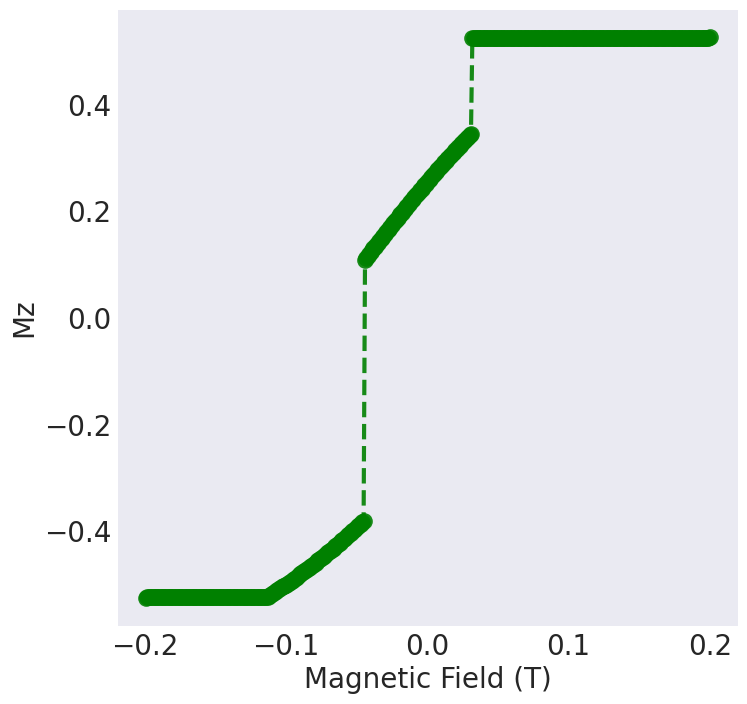

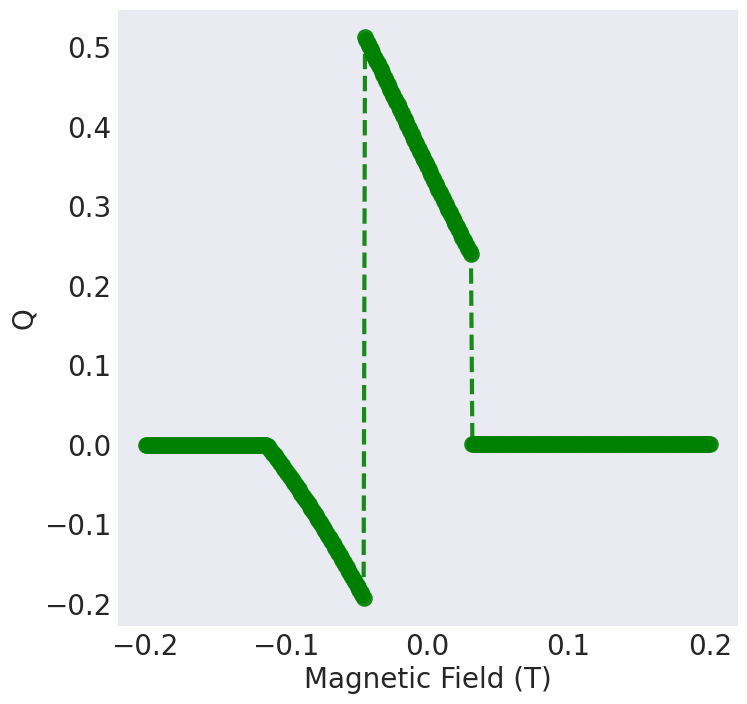

In [22]:
import matplotlib.pyplot as plt
Fig=plt.figure(figsize=(8, 8))
ax1=Fig.add_subplot(1, 1, 1)
ax1.plot(B2_array,mz, 'go', linestyle='--',linewidth=3, markersize=12, alpha=0.9, label='M_x2')
ax1.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Magnetic Field (T)', fontsize=20)
plt.ylabel('Mz', fontsize=20)

Fig=plt.figure(figsize=(8, 8))
ax1=Fig.add_subplot(1, 1, 1)
ax1.plot(B2_array,S, 'go', linestyle='--',linewidth=3, markersize=12, alpha=0.9, label='M_x2')
ax1.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Magnetic Field (T)', fontsize=20)
plt.ylabel('Q', fontsize=20)

Text(0, 0.5, 'Q')

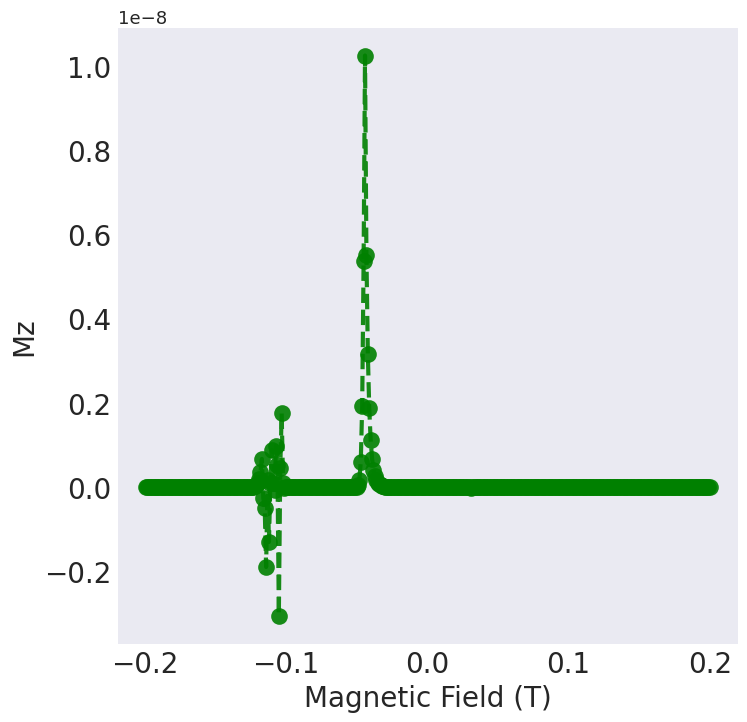

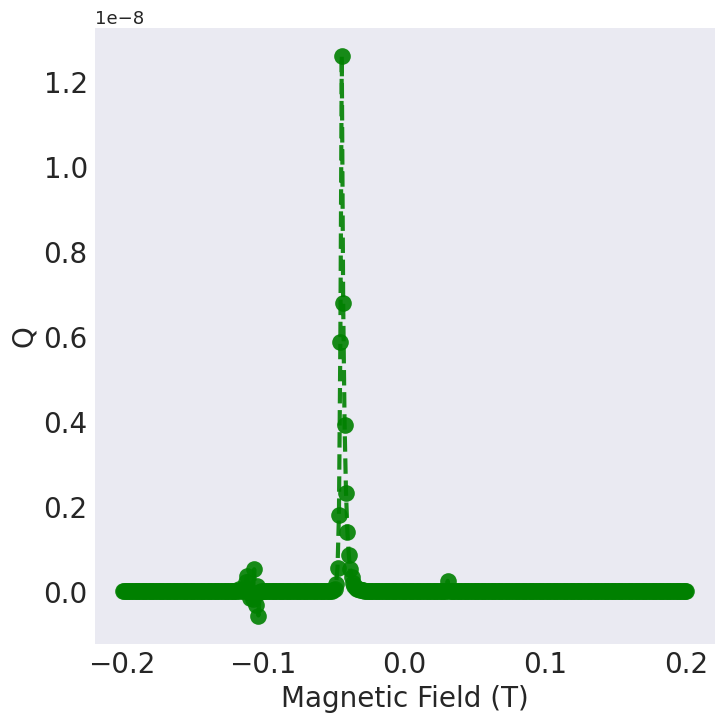

In [23]:
import matplotlib.pyplot as plt
Fig=plt.figure(figsize=(8, 8))
ax1=Fig.add_subplot(1, 1, 1)
ax1.plot(B2_array,mx, 'go', linestyle='--',linewidth=3, markersize=12, alpha=0.9, label='M_x2')
ax1.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Magnetic Field (T)', fontsize=20)
plt.ylabel('Mz', fontsize=20)

Fig=plt.figure(figsize=(8, 8))
ax1=Fig.add_subplot(1, 1, 1)
ax1.plot(B2_array,S1, 'go', linestyle='--',linewidth=3, markersize=12, alpha=0.9, label='M_x2')
ax1.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Magnetic Field (T)', fontsize=20)
plt.ylabel('Q', fontsize=20)

Text(0, 0.5, 'Q')

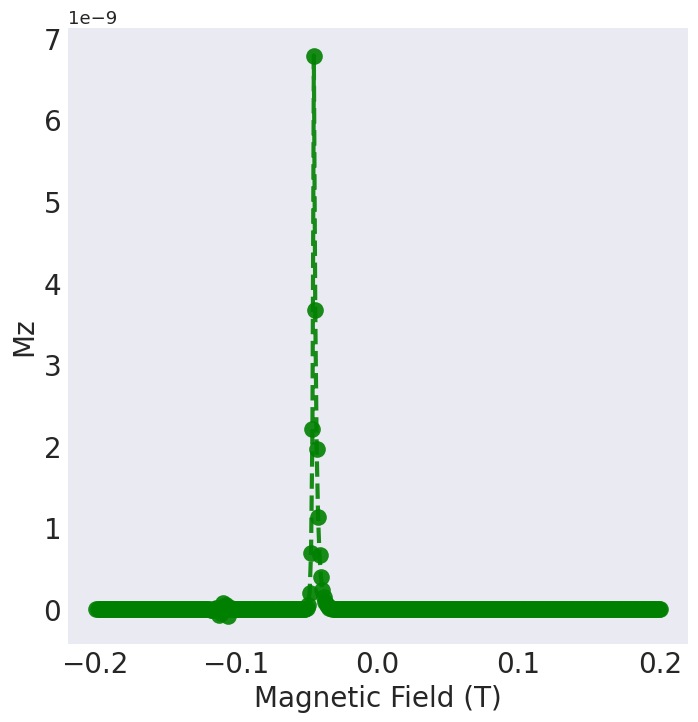

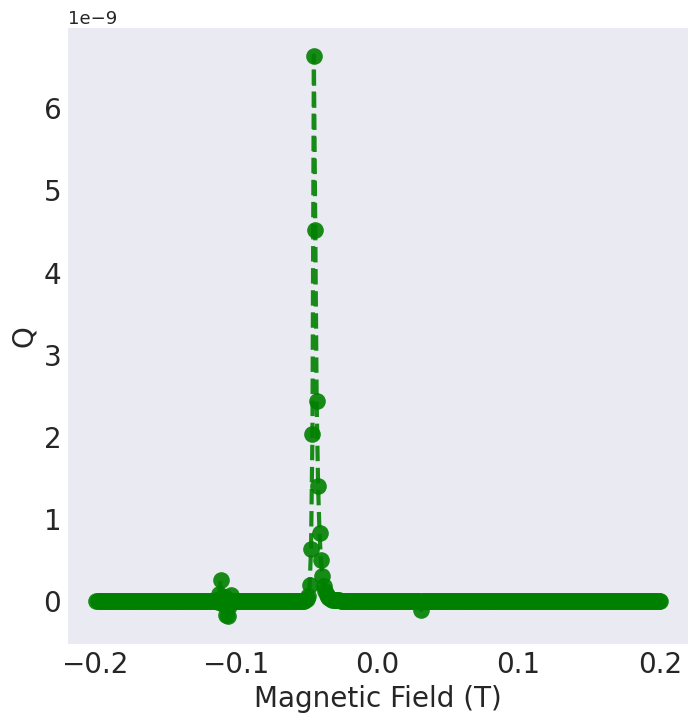

In [24]:
import matplotlib.pyplot as plt
Fig=plt.figure(figsize=(8, 8))
ax1=Fig.add_subplot(1, 1, 1)
ax1.plot(B2_array,my, 'go', linestyle='--',linewidth=3, markersize=12, alpha=0.9, label='M_x2')
ax1.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Magnetic Field (T)', fontsize=20)
plt.ylabel('Mz', fontsize=20)

Fig=plt.figure(figsize=(8, 8))
ax1=Fig.add_subplot(1, 1, 1)
ax1.plot(B2_array,S2, 'go', linestyle='--',linewidth=3, markersize=12, alpha=0.9, label='M_x2')
ax1.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Magnetic Field (T)', fontsize=20)
plt.ylabel('Q', fontsize=20)

In [29]:
print(S)

[0.0002536708769652386, 0.00025438210859291574, 0.0002550966555924952, 0.00025581454689518315, 0.00025653580750779165, 0.00025726044848443507, 0.00025798850764826843, 0.00025871999584316593, 0.00025945494021534015, 0.00026019336193650603, 0.0002609352847366815, 0.00026168073200245553, 0.0002624297274637704, 0.0002631822948125252, 0.0002639384567493038, 0.000264698239381418, 0.00026546166435307357, 0.0002662287583047475, 0.0002669995445081205, 0.0002677740485407802, 0.00026855229519388987, 0.0002693343103087628, 0.0002701201183535994, 0.00027090974504650664, 0.00027170321872869855, 0.0002725005636025831, 0.000273301805861893, 0.00027410697242048423, 0.0002749160903467562, 0.0002757291862846829, 0.0002765462902129414, 0.0002773674256701362, 0.00027819262324018236, 0.0002790219094123588, 0.0002798553148840079, 0.00028069286468475834, 0.0002815345915507487, 0.0002823805218185729, 0.00028323068710877215, 0.000284085113625815, 0.0002849438342148213, 0.0002858068792971882, 0.00028667427731983

In [30]:
print(mz)

[0.5254302654908429, 0.5254300130742395, 0.5254297593927432, 0.5254295044313246, 0.5254292481812208, 0.5254289906335525, 0.5254287317794052, 0.5254284716097686, 0.5254282101155464, 0.5254279472875764, 0.525427683116624, 0.5254274175933398, 0.5254271507083424, 0.5254268824521146, 0.5254266128150796, 0.5254263417875813, 0.5254260693599058, 0.5254257955221835, 0.5254255202645168, 0.5254252435768756, 0.5254249654492087, 0.5254246858712887, 0.525424404832852, 0.525424122323551, 0.5254238383328927, 0.5254235528503438, 0.5254232658652416, 0.5254229773668575, 0.5254226873443488, 0.5254223957867613, 0.5254221026830591, 0.5254218080221144, 0.5254215117926928, 0.5254212139834121, 0.5254209145828562, 0.5254206135794919, 0.5254203109616289, 0.5254200067175196, 0.5254197008352854, 0.5254193933029643, 0.525419084108441, 0.525418773239499, 0.5254184606838863, 0.5254181464291183, 0.5254178304626616, 0.5254175127718637, 0.5254171933439328, 0.525416872165968, 0.5254165492249515, 0.5254162245077549, 0.525

In [31]:
B2 = B2_array.tolist()

In [32]:
print(B2)

[0.2, 0.199, 0.198, 0.197, 0.196, 0.195, 0.194, 0.193, 0.192, 0.191, 0.19, 0.189, 0.188, 0.187, 0.186, 0.185, 0.184, 0.183, 0.182, 0.181, 0.18, 0.179, 0.178, 0.177, 0.176, 0.175, 0.174, 0.173, 0.172, 0.17099999999999999, 0.16999999999999998, 0.16899999999999998, 0.16799999999999998, 0.16699999999999998, 0.16599999999999998, 0.16499999999999998, 0.16399999999999998, 0.16299999999999998, 0.16199999999999998, 0.16099999999999998, 0.15999999999999998, 0.15899999999999997, 0.15799999999999997, 0.15699999999999997, 0.15599999999999997, 0.15499999999999997, 0.15399999999999997, 0.15299999999999997, 0.15199999999999997, 0.15099999999999997, 0.14999999999999997, 0.14899999999999997, 0.14799999999999996, 0.14699999999999996, 0.14599999999999996, 0.14499999999999996, 0.14399999999999996, 0.14299999999999996, 0.14199999999999996, 0.14099999999999996, 0.13999999999999996, 0.13899999999999996, 0.13799999999999996, 0.13699999999999996, 0.13599999999999995, 0.13499999999999995, 0.13399999999999995, 0.

In [16]:
S[49]

0.00029287058344019647